# Ну что ж, давайте обучать #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')

In [2]:
train = pd.read_excel('semifinal_data/train.xlsx')
test = pd.read_excel('semifinal_data/test.xlsx')
descr = pd.read_excel('semifinal_data/description.xlsx')

## Строковые признаки ##

Сделаем mean encodings первых двух слов признаков GmWt_Desc1 и GmWt_Desc2.

In [3]:
def handle_desc(x, param):
    if (x != x) and (param == 0):
        return np.NaN
    elif (x != x):
        return 'nan'
    tup = x.lower().replace(',', '').split(' ')[:2]
    if param == 0:
        return float(tup[0])
    elif param == 1:
        return tup[1]
    else:
        return ' '.join(tup)

In [4]:
from sklearn.model_selection import KFold

for col in ['GmWt_Desc1', 'GmWt_Desc2']:
    train[col + '_first'] = train[col].apply(lambda x: handle_desc(x, 0))
    test[col + '_first'] = test[col].apply(lambda x: handle_desc(x, 0))

    train[col + '_second'] = train[col].apply(lambda x: handle_desc(x, 1))
    test[col + '_second'] = test[col].apply(lambda x: handle_desc(x, 1))

    train[col + '_pair'] = train[col].apply(lambda x: handle_desc(x, 2))
    test[col + '_pair'] = test[col].apply(lambda x: handle_desc(x, 2))
    
    cv = KFold(n_splits = 5, shuffle = True)

    for cur_col in [col + '_second', col + '_pair']:
        globalmean = train['Energ_Kcal'].mean()
        train[cur_col + '_encoded'] = 0.
        for train_idx, test_idx in cv.split(train):
            mapping = train.loc[train_idx].groupby(cur_col)['Energ_Kcal'].mean()
            train[cur_col + '_encoded'][test_idx] = train[cur_col][test_idx].map(mapping)
        train[cur_col + '_encoded'].fillna(globalmean, inplace=True) 
        mapping = train.groupby(cur_col)['Energ_Kcal'].mean()
        test[cur_col + '_encoded'] = test[cur_col].map(mapping)
        test[cur_col + '_encoded'].fillna(globalmean, inplace=True)

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Теперь посчитаем TF IDF описаний.

In [7]:
data = pd.concat([train, test], sort=False)
data.shape

(8618, 62)

In [8]:
def handle_shrt_desc(x):
    new = ''
    for el in x.lower():
        if el.isalpha():
            new += el
        else:
            new += ' '
    return new

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

pd_corpus = data['Shrt_Desc'].apply(handle_shrt_desc)
corpus = list(pd_corpus.values)

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)

nmf = NMF(n_components = 5)
word_nmf = nmf.fit_transform(tfidf)
word_cols = ['word_TF-IDF-' + str(i) for i in range(5)]
data = pd.concat([data.reset_index(drop=True), pd.DataFrame(word_nmf, columns = word_cols)], 
                 axis = 1, sort = False)

In [15]:
data.columns

Index(['Shrt_Desc', 'Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Lipid_Tot_(g)',
       'Ash_(g)', 'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Sugar_Tot_(g)',
       'Calcium_(mg)', 'Iron_(mg)', 'Magnesium_(mg)', 'Phosphorus_(mg)',
       'Potassium_(mg)', 'Sodium_(mg)', 'Zinc_(mg)', 'Copper_mg)',
       'Manganese_(mg)', 'Selenium_(µg)', 'Vit_C_(mg)', 'Thiamin_(mg)',
       'Riboflavin_(mg)', 'Niacin_(mg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)',
       'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)',
       'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_IU', 'Retinol_(µg)',
       'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)',
       'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_IU',
       'Vit_K_(µg)', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'GmWt_Desc1', 'GmWt_2', 'GmWt_Desc2',
       'Refuse_Pct', 'GmWt_Desc1_first', 'GmWt_Desc1_second',
       'GmWt_Desc1_pair', 'GmWt_Desc1_second_encoded',
       'GmWt_Desc1_pair_encoded', 'GmWt_De

## Работа с числовыми признаками ##

Отбросим сильно коррелирующие признаки (смотри ноутбук с EDA).

In [13]:
data.drop(['Vit_D_µg', 'Vit_A_RAE', 'Folate_Tot_(µg)'], axis=1, inplace=True)

Добавим признак "число NaNов в строке", заполним NaNы в числовых признаках медианами.

In [16]:
data['Energ_Kcal'].fillna(-1., inplace=True)
data['NaN_number'] = data.isnull().sum(axis=1)

float_cols = list(set(data.columns) - {'GmWt_Desc2_pair', 'GmWt_Desc2_second', 'GmWt_Desc1_pair', \
                                       'GmWt_Desc1', 'GmWt_Desc2', 'Shrt_Desc', 'Energ_Kcal', \
                                      'GmWt_Desc1_second'})
for col in float_cols:
    data[col].fillna(data[col].median(), inplace=True)

Нормализуем числовые признаки.

In [17]:
from sklearn.preprocessing import StandardScaler

for col in float_cols:
    data[col] = StandardScaler().fit_transform(data[col].values.reshape(-1, 1))

Выкинем лишнее.

In [18]:
str_cols = ['GmWt_Desc1', 'GmWt_Desc2', 'Shrt_Desc', 'GmWt_Desc2_pair', 'GmWt_Desc2_second', 'GmWt_Desc1_pair',
           'GmWt_Desc1_second']
data.drop(str_cols, axis=1, inplace=True)

Вернемся к трейну и тесту и нормализуем целевую переменную.

In [19]:
from sklearn.preprocessing import StandardScaler

train = data[data['Energ_Kcal'] != -1]
test = data[data['Energ_Kcal'] == -1]
test.drop('Energ_Kcal', axis=1, inplace=True)

scaler = StandardScaler()
scaler.fit(train['Energ_Kcal'].values.reshape(-1, 1))
train['Energ_Kcal'] = scaler.transform(train['Energ_Kcal'].values.reshape(-1, 1))

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/data_sapiens/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Попробуем обучить что-нибудь простенькое ##

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop('Energ_Kcal', axis=1), train['Energ_Kcal'], 
                                                   shuffle=True)

Нам понадобится особенная метрика (из-за того, что мы скалировали)

In [21]:
from sklearn.metrics import mean_absolute_error

def metric(y_pred, y_true, dmatrix=True):
    if dmatrix:
        y_true_rescaled = scaler.inverse_transform(y_true.get_label().reshape(-1, 1))
    else:
        y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    return ('mae', mean_absolute_error(y_true_rescaled, y_pred_rescaled))

In [22]:
from __future__ import print_function
from xgboost import XGBRegressor
from IPython.utils import io

model = XGBRegressor(n_estimators=1200)
with io.capture_output() as captured:
    model.fit(X_train.values, y_train.values, eval_set=[(X_train.values, y_train.values),
              (X_test.values, y_test.values)], eval_metric=metric, verbose=True)

print('MAE на валидационном сете: ', metric(model.predict(X_test.values), y_test.values, False))

MAE на валидационном сете:  ('mae', 5.642752981296577)


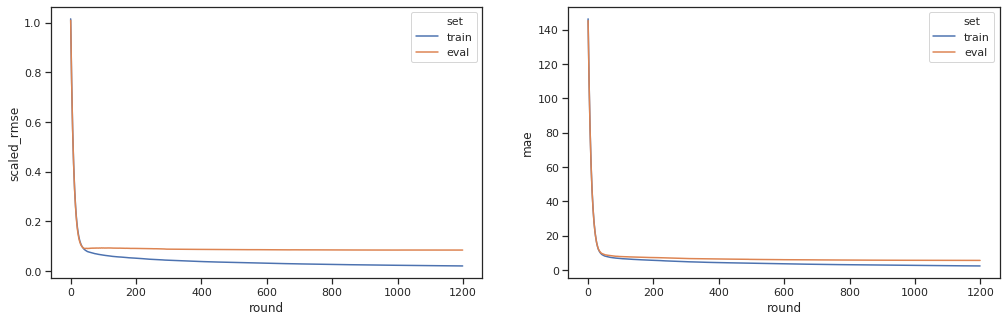

In [23]:
info = captured.stdout.split('\t')[1:]
curve = [[], [], [], []]
for i in range(0, len(info)):
    score = float(info[i].split(':')[1].split('\n')[0])
    curve[i % 4].append(score)

rounds = len(curve[0])

index = np.array([[i, i] for i in range(rounds)]).reshape((2 * rounds,))
np_curve = np.array(curve).T
np_curve[:, [1, 2]] = np_curve[:, [2, 1]]
pd_curve = pd.DataFrame(np_curve.reshape((2 * rounds, 2)), columns=['scaled_rmse', 'mae'])
pd_curve['round'] = index
pd_curve['set'] = np.array([['train', 'eval'] for i in range(rounds)]).reshape((2 * rounds,))

f, axes = plt.subplots(1, 2, figsize=(17, 5))

sns.lineplot(data=pd_curve, x='round', y='scaled_rmse', hue='set', ax=axes[0])
sns.lineplot(data=pd_curve, x='round', y='mae', hue='set', ax=axes[1])

## Важные признаки ##

In [24]:
cols = X_train.columns
importances = pd.Series(model.feature_importances_, cols)
importances.sort_values(ascending=False, inplace=True)

print('5 наиболее важных признаков:')
importances.head()

5 наиболее важных признаков:


Water_(g)         0.603753
Lipid_Tot_(g)     0.342266
Ash_(g)           0.013924
Carbohydrt_(g)    0.008862
Fiber_TD_(g)      0.003561
dtype: float32

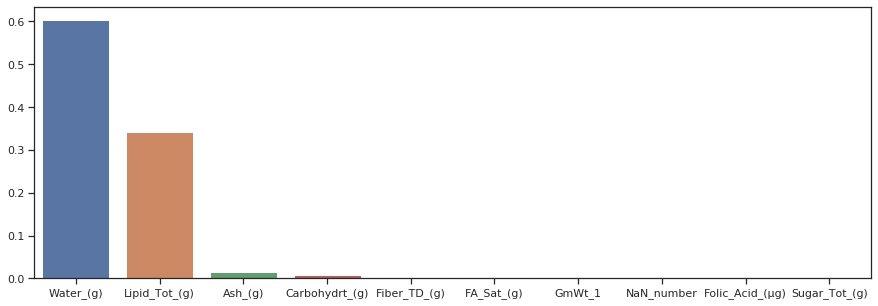

In [25]:
plt.figure(figsize=(15, 5))
sns.barplot(x=importances[:10].index, y=importances[:10].values)

## Предсказание ##

In [13]:
test_pred = model.predict(test.values)
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
answer = pd.Series(test_pred.reshape(-1), name='Pred_kcal')
answer.to_csv('semifinal_files/baseline1.csv', index=False, header=True)